In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, re

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 80)
pd.set_option('display.max_rows', 100)

sys.path.append('/net/pulsar/home/koes/mtr22')
import param_search

expt_dir = '/net/pulsar/home/koes/mtr22/gan/torch_training'
os.chdir(expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/torch_training'

In [249]:
template_file = 'train.sh'
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=18
#SBATCH --partition=dept_gpu
#SBATCH --gres=gpu:1
#SBATCH --mem=64gb
#SBATCH --time=672:00:00
#SBATCH --qos=normal
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --dependency=singleton
#SBATCH --mail-type=fail
#SBATCH --mail-user=mtr22@pitt.edu
{job_params}
source ~/.bashrc
cd $SLURM_SUBMIT_DIR

python3 $LIGAN_ROOT/train.py \\
    --random_seed {random_seed} \\
    --data_root {data_root} \\
    --rec_molcache {rec_molcache} \\
    --lig_molcache {lig_molcache} \\
    --train_file {train_file} \\
    --test_file {test_file} \\
    --batch_size {batch_size} \\
    --rec_map_file {rec_map_file} \\
    --lig_map_file {lig_map_file} \\
    --model_type {model_type} \\
    --skip_connect {skip_connect} \\
    --kldiv_loss_wt {kldiv_loss_wt} \\
    --recon_loss_wt {recon_loss_wt} \\
    --gan_loss_type {gan_loss_type} \\
    --gan_loss_wt {gan_loss_wt} \\
    --gen_grad_norm_type {gen_grad_norm_type} \\
    --disc_grad_norm_type {disc_grad_norm_type} \\
    --max_iter {max_iter} \\
    --test_interval {test_interval} \\
    --n_test_batches {n_test_batches} \\
    --save_interval {save_interval} \\
    --out_prefix {job_name}
'''
with open(template_file, 'w') as f:
    f.write(template)

In [250]:
# for ligand-only models
lig_only_param_space = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/mtr22/molport',
    rec_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_lig.molcache2',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_test0.types',
    skip_connect=False
)

# for receptor-conditional models
rec_cond_param_space = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/paf46/Research/CrossDocking_script/PocketomeOutput/PocketomeGenCross_Output',
    rec_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_rec.molcache2',
    lig_molcache='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/models/crossdock2020_lig.molcache2',
    train_file='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_train0.types',
    test_file='/net/pulsar/home/koes/paf46/git/cnnaffinitypaper/types/it2_tt_0_test0.types',
    skip_connect=True
)

# general parameters
general_param_space = param_search.ParamSpace(
    random_seed=[0, 1, 2],
    batch_size=10,
    rec_map_file='/net/pulsar/home/koes/mtr22/gan/data/my_rec_map',
    lig_map_file='/net/pulsar/home/koes/mtr22/gan/data/my_lig_map',
    kldiv_loss_wt=0.1,
    recon_loss_wt=1,
    gen_grad_norm_type='2',
    disc_grad_norm_type='2',
    max_iter=100000,
    test_interval=100,
    n_test_batches=10,
    fit_interval=1000,
    save_interval=10000,
    n_latent=[128, 256, 1024],
)

lig_only_param_space.update(general_param_space)
rec_cond_param_space.update(general_param_space)

# model type-specific parameters
ae_vae_param_space = param_search.ParamSpace(
    model_type=['AE', 'VAE'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='0',
    extra_sbatch_line='',
    **lig_only_param_space,
)

ce_cvae_param_space = param_search.ParamSpace(
    model_type=['CE', 'CVAE'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='0',
    extra_sbatch_line='',
    **rec_cond_param_space,
)

gan_param_space = param_search.ParamSpace(
    model_type=['GAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    gan_loss_wt=1,
    extra_sbatch_line='',
    **lig_only_param_space,
)

wgan_param_space = param_search.ParamSpace(
    model_type=['GAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    gan_loss_wt=1,
    extra_sbatch_line='',
    **lig_only_param_space,
)

cgan_param_space = param_search.ParamSpace(
    model_type=['CGAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    gan_loss_wt=1,
    extra_sbatch_line='',
    **rec_cond_param_space,
)

cwgan_param_space = param_search.ParamSpace(
    model_type=['CGAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    gan_loss_wt=1,
    extra_sbatch_line='',
    **rec_cond_param_space,
)

# dual encoder models require 12gb GPUs

vaegan_param_space = param_search.ParamSpace(
    model_type=['VAEGAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    gan_loss_wt=10,
    extra_sbatch_line='#SBATCH -C M12',
    **lig_only_param_space,
)

vaewgan_param_space = param_search.ParamSpace(
    model_type=['VAEGAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    gan_loss_wt=1,
    extra_sbatch_line='#SBATCH -C M12',
    **lig_only_param_space,
)

cvaegan_param_space = param_search.ParamSpace(
    model_type=['CVAEGAN'],
    optim_type=['Adam'],
    learning_rate=[1e-5],
    gan_loss_type='x',
    gan_loss_wt=10,
    extra_sbatch_line='#SBATCH -C M12',
    **rec_cond_param_space,
)

cvaewgan_param_space = param_search.ParamSpace(
    model_type=['CVAEGAN'],
    optim_type=['RMSprop'],
    learning_rate=[1e-7],
    gan_loss_type='w',
    gan_loss_wt=1,
    extra_sbatch_line='#SBATCH -C M12',
    **rec_cond_param_space,
)

all_param_spaces = [

    gan_param_space,
    wgan_param_space,
    cgan_param_space,
    cwgan_param_space,
    vaegan_param_space,
    vaewgan_param_space,
    cvaegan_param_space,
    cvaewgan_param_space,

    #ae_vae_param_space,
    #ce_cvae_param_space,
]

[len(p) for p in all_param_spaces]

[9, 9, 9, 9, 9, 9, 9, 9]

In [251]:
job_files = param_search.setup(
    expt_dir=expt_dir,
    name_format='train_{model_type}_8_{n_latent}_{gan_loss_type}_{random_seed}',
    template_file='train.sh',
    param_space=sum(map(list, all_param_spaces), [])
)
len(job_files) 

72

# Submit training jobs to cluster

In [252]:
job_ids = param_search.submit(job_files)
print(job_ids)

[6736473, 6736474, 6736475, 6736476, 6736477, 6736478, 6736479, 6736480, 6736481, 6736482, 6736483, 6736484, 6736485, 6736486, 6736487, 6736488, 6736489, 6736490, 6736491, 6736492, 6736493, 6736494, 6736495, 6736496, 6736497, 6736498, 6736499, 6736500, 6736501, 6736502, 6736503, 6736504, 6736505, 6736506, 6736507, 6736508, 6736509, 6736510, 6736511, 6736512, 6736513, 6736514, 6736515, 6736516, 6736517, 6736518, 6736519, 6736520, 6736521, 6736522, 6736523, 6736524, 6736525, 6736526, 6736527, 6736528, 6736529, 6736530, 6736531, 6736532, 6736533, 6736534, 6736535, 6736536, 6736537, 6736538, 6736539, 6736540, 6736541, 6736542, 6736543, 6736544]


In [256]:
import numpy as np
import glob

experiment = pd.DataFrame(dict(
    group_name=[
        'non_gan', # non-GANs and WGANs, no atom fitting - the WGANs all diverged to nan, non-GAN still going strong
        'train_fitting', # try 3 random seeds, 3 latent sizes, GANs + WGANs, and atom fitting metrics - VAEGANs oom, GANs nan
        'train_fitting2', # use gen+disc gradient clipping, 64gb mem, resubmit
    ],
    job_id=[
        [6733823, 6733824, 6733825, 6733826],
        [6736277, 6736278, 6736279, 6736280, 6736281, 6736282, 6736283, 6736284, 6736285, 6736286, 6736287, 6736288, 6736289, 6736290, 6736291, 6736292, 6736293, 6736294, 6736295, 6736296, 6736297, 6736298, 6736299, 6736300, 6736301, 6736302, 6736303, 6736304, 6736305, 6736306, 6736307, 6736308, 6736309, 6736310, 6736311, 6736312, 6736313, 6736314, 6736315, 6736316, 6736317, 6736318, 6736319, 6736320, 6736321, 6736322, 6736323, 6736324, 6736325, 6736326, 6736327, 6736328, 6736329, 6736330, 6736331, 6736332, 6736333, 6736334, 6736335, 6736336, 6736337, 6736338, 6736339, 6736340, 6736341, 6736342, 6736343, 6736344, 6736345, 6736346, 6736347, 6736348],
        [6736473, 6736474, 6736475, 6736476, 6736477, 6736478, 6736479, 6736480, 6736481, 6736482, 6736483, 6736484, 6736485, 6736486, 6736487, 6736488, 6736489, 6736490, 6736491, 6736492, 6736493, 6736494, 6736495, 6736496, 6736497, 6736498, 6736499, 6736500, 6736501, 6736502, 6736503, 6736504, 6736505, 6736506, 6736507, 6736508, 6736509, 6736510, 6736511, 6736512, 6736513, 6736514, 6736515, 6736516, 6736517, 6736518, 6736519, 6736520, 6736521, 6736522, 6736523, 6736524, 6736525, 6736526, 6736527, 6736528, 6736529, 6736530, 6736531, 6736532, 6736533, 6736534, 6736535, 6736536, 6736537, 6736538, 6736539, 6736540, 6736541, 6736542, 6736543, 6736544],
    ]
)).explode('job_id')
experiment.groupby('group_name')['job_id'].agg(['count', 'min', 'max'])

,count,min,max
group_name,,,
non_gan,4,6733823,6733826
train_fitting,72,6736277,6736348
train_fitting2,72,6736473,6736544


In [241]:
import param_search

queue_status = param_search.status()
queue_status[['job_id', 'array_idx']] = queue_status.job_id.str.split('_', expand=True).apply(pd.to_numeric)
queue_status[queue_status.user == 'mtr22']

df = experiment.merge(queue_status, on='job_id', how='left')

def find_work_dir(x):
    if not pd.isnull(x['work_dir']):
        return x['work_dir']
    f = glob.glob('*/{}.*'.format(x['job_id']))
    if f:
        return os.path.dirname(f[0])
    else:
        return None # cancelled before running

def find_job_state(x):
    if not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=FileNotFoundError, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

df['work_dir'] = df.apply(find_work_dir, axis=1)
df['job_name'] = df['work_dir'].map(catch_exc(os.path.basename, TypeError))
df['stdout_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
df['stderr_file'] = df.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
df['stdout'] = df['stdout_file'].map(catch_exc(param_search.job_output.read_stdout_file))
df['stderr'] = df['stderr_file'].map(catch_exc(param_search.job_output.read_stderr_file))
df['job_state'] = df.apply(find_job_state, axis=1)
df.set_index(['group_name', 'job_id', 'job_name'])[['job_state', 'stdout', 'stderr']]

job_state  \
group_name    job_id  job_name                            
non_gan       6733823 train_AE_7                      R   
              6733824 train_VAE_7                     R   
              6733825 train_CE_7                      R   
              6733826 train_CVAE_7                    R   
train_fitting 6736277 train_VAEGAN_8_1024_x_1       ERR   
              6736278 train_VAEGAN_8_256_x_2        ERR   
              6736279 train_VAEGAN_8_128_w_0        ERR   
              6736280 train_VAEGAN_8_1024_w_0       ERR   
              6736281 train_VAEGAN_8_128_w_1        ERR   
              6736282 train_VAEGAN_8_1024_w_1       ERR   
              6736283 train_VAEGAN_8_256_w_2        ERR   
              6736284 train_VAEGAN_8_1024_w_2       ERR   
              6736285 train_CVAEGAN_8_256_x_0       ERR   
              6736286 NaN                           CAN   
              6736287 NaN                           CAN   
              6736288 NaN                           CAN   
              6736289 NaN                           CAN   
              6736290 NaN                           CAN   
              6736291 NaN                           CAN   
              6736292 NaN                           CAN   
              6736293 NaN                           CAN   
              6736294 NaN                           CAN   
              6736295 train_GAN_8_128_x_0           ERR   
              6736296 train_GAN_8_256_x_0           ERR   
              6736297 train_GAN_8_1024_x_0          ERR   
              6736298 train_GAN_8_128_x_1           ERR   
              6736299 NaN                           CAN   
              6736300 NaN                           CAN   
              6736301 NaN                           CAN   
              6736302 NaN                           CAN   
              6736303 NaN                           CAN   
              6736304 NaN                           CAN   
              6736305 NaN                           CAN   
              6736306 NaN                           CAN   
              6736307 NaN                           CAN   
              6736308 NaN                           CAN   
              6736309 NaN                           CAN   
              6736310 NaN                           CAN   
              6736311 NaN                           CAN   
              6736312 NaN                           CAN   
              6736313 NaN                           CAN   
              6736314 NaN                           CAN   
              6736315 NaN                           CAN   
              6736316 NaN                           CAN   
              6736317 NaN                           CAN   
              6736318 NaN                           CAN   
              6736319 NaN                           CAN   
              6736320 NaN                           CAN   
              6736321 NaN                           CAN   
              6736322 NaN                           CAN   
              6736323 NaN                           CAN   
              6736324 NaN                           CAN   
              6736325 NaN                           CAN   
              6736326 NaN                           CAN   
              6736327 NaN                           CAN   
              6736328 NaN                           CAN   
              6736329 NaN                           CAN   
              6736330 NaN                           CAN   
              6736331 NaN                           CAN   
              6736332 NaN                           CAN   
              6736333 NaN                           CAN   
              6736334 NaN                           CAN   
              6736335 NaN                           CAN   
              6736336 NaN                           CAN   
              6736337 NaN                           CAN   
              6736338 NaN                           CAN   
              6736339 NaN         

In [237]:
if False:
    param_search.cancel(' '.join(map(str, df[df.group_name == 'train_fitting'].job_id)))

''

# Read in training output metrics

In [190]:
# READ IN METRIC FILES
metrics = param_search.metrics(glob.glob('train_*_8_*/train.sh'), metric_pat='(.*)\.metrics')

train_VAEGAN_8_1024_x_1/train.sh No objects to concatenate
train_VAEGAN_8_1024_w_0/train.sh No objects to concatenate
train_VAEGAN_8_128_w_1/train.sh No objects to concatenate
train_VAEGAN_8_256_w_2/train.sh No objects to concatenate
train_VAEGAN_8_1024_w_2/train.sh No objects to concatenate
train_CVAEGAN_8_128_x_1/train.sh No objects to concatenate
train_CVAEGAN_8_256_x_1/train.sh No objects to concatenate
train_CVAEGAN_8_128_x_2/train.sh No objects to concatenate
train_CVAEGAN_8_1024_x_2/train.sh No objects to concatenate
train_CVAEGAN_8_128_w_0/train.sh No objects to concatenate
train_CVAEGAN_8_1024_w_0/train.sh No objects to concatenate
train_CVAEGAN_8_256_w_1/train.sh No objects to concatenate
train_CVAEGAN_8_1024_w_1/train.sh No objects to concatenate
train_CVAEGAN_8_256_w_2/train.sh No objects to concatenate
train_GAN_8_256_x_1/train.sh No objects to concatenate
train_GAN_8_1024_x_1/train.sh No objects to concatenate
train_GAN_8_128_x_2/train.sh No objects to concatenate
train_G

In [194]:
def dtype(s):
    return s.dtype

metric_index_cols = ['iteration', 'disc_iter', 'phase', 'model', 'batch']
all_index_cols = list(rec_cond_param_space.keys()) + metric_index_cols

metrics[all_index_cols].agg([dtype, pd.Series.nunique, pd.Series.unique]).transpose()

,dtype,nunique,unique
data_root,object,2,"[/net/pulsar/home/koes/mtr22/molport, /net/pulsar/home/koes/paf46/Research/CrossDocking_script/P..."
rec_molcache,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rec.molcache2, /net/pulsar/home/koes/paf46/git..."
lig_molcache,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_lig.molcache2, /net/pulsar/home/koes/paf46/git..."
train_file,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_train0.types, /net/pulsar/home/koes/paf46..."
test_file,object,2,"[/net/pulsar/home/koes/mtr22/gan/data/molportFULL_rand_test0.types, /net/pulsar/home/koes/paf46/..."
skip_connect,bool,2,"[False, True]"
random_seed,int64,3,"[2, 0, 1]"
batch_size,int64,1,[10]
rec_map_file,object,1,[/net/pulsar/home/koes/mtr22/gan/data/my_rec_map]
lig_map_file,object,1,[/net/pulsar/home/koes/mtr22/gan/data/my_lig_map]


In [195]:
#metrics['iteration'] = metrics['iteration'].mask(metrics['iteration'].isna(), metrics['gen_iter'], axis=0)
#metrics['recon_loss_fixed'] = metrics['recon_loss'] * (19*48*48*48) / 2

metrics['model'] = metrics['model'].fillna('gen')
metrics['real'] = metrics['real'].fillna(False)

metrics[
    metrics['iteration'] == metrics.groupby('model_type')['iteration'].transform(max)
].groupby(['model_type', 'iteration', 'phase', 'model'])[
    ['loss', 'kldiv_loss', 'recon_loss', 'gan_loss', 'gen_grad_norm', 'disc_grad_norm', 'lig_norm', 'lig_gen_norm']
].mean()

loss    kldiv_loss    recon_loss  \
model_type iteration phase model                                             
CVAEGAN    41300     test  disc            NaN           NaN           NaN   
                           gen             NaN           NaN           NaN   
GAN        65800     test  disc            NaN           NaN           NaN   
                           gen             NaN           NaN           NaN   
VAEGAN     50600     test  disc   1.572653e+31  1.011927e+22  1.940239e+28   
                           gen   -3.185392e+31  1.005580e+22  1.924106e+28   

                                      gan_loss  gen_grad_norm  disc_grad_norm  \
model_type iteration phase model                                                
CVAEGAN    41300     test  disc            NaN            NaN             NaN   
                           gen             NaN            NaN             NaN   
GAN        65800     test  disc            NaN            NaN             NaN   
                           gen             NaN            NaN             NaN   
VAEGAN     50600     test  disc   1.571683e+31            NaN             NaN   
                           gen   -3.187316e+31            NaN             NaN   

                                   lig_norm  lig_gen_norm  
model_type iteration phase model                           
CVAEGAN    41300     test  disc   36.272277           NaN  
                           gen    37.963648           NaN  
GAN        65800     test  disc   38.342677           NaN  
                           gen          NaN           NaN  
VAEGAN     50600     test  disc   38.800762  1.793679e+14  
                           gen    38.355567  1.818718e+14

/net/pulsar/home/koes/mtr22/param_search/results.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[group] = df[group_cols].apply(make_group_value, axis=1)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degree

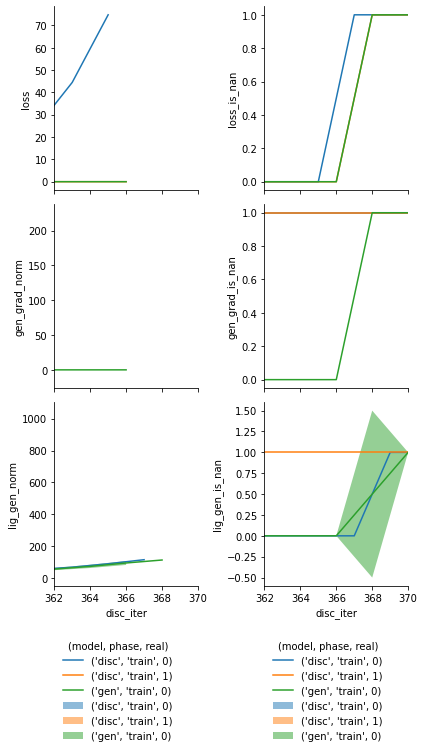

In [230]:
import numpy as np
import scipy.stats
import param_search

def filled_lines(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue):
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(scipy.stats.sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h)
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
iter_bin_size = 100
metrics['iter_bin'] = ((metrics['iteration'] // iter_bin_size) * iter_bin_size).astype(int)
metrics['loss_is_nan'] = metrics['loss'].isnull()
metrics['gen_grad_is_nan'] = metrics['gen_grad_norm'].isnull()
metrics['lig_gen_is_nan'] = metrics['lig_gen_norm'].isnull()

model_types0 = ['AE', 'CE', 'VAE', 'CVAE']
model_types1 = ['GAN', 'CGAN', 'VAEGAN', 'CVAEGAN']

fig = param_search.plot(
    metrics[
        (metrics['job_name'] == 'train_GAN_8_256_x_0') &
        (metrics['iteration'] <= 1000) &
        (metrics['phase'] == 'train')
    ],
    x='disc_iter',
    y=[
        'loss', 'loss_is_nan', #'kldiv_loss', 'recon_loss', 'gan_loss',
        'gen_grad_norm', 'gen_grad_is_nan', # 'gen_grad_norm', 'disc_grad_norm',
        'lig_gen_norm', 'lig_gen_is_nan', #'lig_n_atoms', 'lig_gen_fit_n_atoms'
    ],
    xlim=dict(disc_iter=[362, 370]),
    ylim=dict(),
    hue=('model', 'phase', 'real'),
    plot_func=filled_lines,
    n_cols=2, height=3.5
)

In [204]:
metrics.columns

Index(['iteration', 'disc_iter', 'phase', 'model', 'batch', 'real', 'loss',
       'gan_loss', 'lig_norm', 'lig_variance', 'forward_data_time',
       'forward_gen_time', 'forward_disc_time', 'forward_metrics_time',
       'forward_time', 'recon_loss', 'kldiv_loss', 'lig_gen_norm',
       'lig_gen_variance', 'lig_gen_L2_loss', 'lig_gen_fit_n_atoms',
       'lig_gen_fit_radius', 'lig_n_atoms', 'lig_radius',
       'lig_gen_fit_type_diff', 'lig_gen_fit_exact_types',
       'lig_gen_fit_atom_rmsd', 'forward_fit_time', 'disc_grad_norm',
       'backward_time', 'backward_grad_time', 'backward_norm_time',
       'backward_update_time', 'gen_grad_norm', 'model_type', 'optim_type',
       'learning_rate', 'gan_loss_type', 'gan_loss_wt', 'extra_sbatch_line',
       'data_root', 'rec_molcache', 'lig_molcache', 'train_file', 'test_file',
       'skip_connect', 'random_seed', 'batch_size', 'rec_map_file',
       'lig_map_file', 'kldiv_loss_wt', 'recon_loss_wt', 'disc_grad_norm_type',
       'max_i